# EM for Linear-Gaussian Models

This notebook shows how one may use the EM algorithm to estimate model
parameters with a Kalman Filter.

The EM algorithm is a meta-algorithm for learning parameters in probabilistic
models. The algorithm works by first fixing the parameters and finding a closed
form distribution over the unobserved variables, then finds new parameters that
maximize the expected likelihood of the observed variables (where the
expectation is taken over the unobserved ones). Due to convexity arguments, we
are guaranteed that each iteration of the algorithm will increase the
likelihood of the observed data and that it will eventually reach a local
optimum.

The EM algorithm is applied to the Linear-Gaussian system (that is, the model
assumed by the Kalman Filter) by first using the Kalman Smoother to calculate
the distribution over all unobserved variables (in this case, the hidden target
states), then closed-form update equations are used to update the model
parameters.

The first figure plotted contains 4 sets of lines. The first, labeled `true`,
represents the true, unobserved state of the system. The second, labeled
`blind`, represents the predicted state of the system if no measurements are
incorporated.  The third, labeled `filtered`, are the state estimates given
measurements up to and including the current time step.  Finally, the fourth,
labeled `smoothed`, are the state estimates using all observations for all time
steps.  The latter three estimates use parameters learned via 10 iterations of
the EM algorithm.

The second figure contains a single line representing the likelihood of the
observed data as a function of the EM Algorithm iteration.


First, import the necessary libraries.

This example requires **numpy**, **matplotlib** and **pykalman**

In [3]:
import numpy as np
import matplotlib.pyplot as pl

from pykalman.datasets import load_robot
from pykalman import KalmanFilter

Load data and initialize Kalman Filter.

In [4]:
data = load_robot()
kf = KalmanFilter(
    data.transition_matrix,
    data.observation_matrix,
    data.initial_transition_covariance,
    data.initial_observation_covariance,
    data.transition_offsets,
    data.observation_offset,
    data.initial_state_mean,
    data.initial_state_covariance,
    em_vars=[
        "transition_matrices",
        "observation_matrices",
        "transition_covariance",
        "observation_covariance",
        "observation_offsets",
        "initial_state_mean",
        "initial_state_covariance",
    ],
)

Learn good values for parameters named in `em_vars` using the EM algorithm.

In [5]:
loglikelihoods = np.zeros(10)
for i in range(len(loglikelihoods)):
    kf = kf.em(X=data.observations, n_iter=1)
    loglikelihoods[i] = kf.loglikelihood(data.observations)

Estimate the state without using any observations.  

This will let us see how good we could do if we ran blind.

In [6]:
n_dim_state = data.transition_matrix.shape[0]
n_timesteps = data.observations.shape[0]
blind_state_estimates = np.zeros((n_timesteps, n_dim_state))
for t in range(n_timesteps - 1):
    if t == 0:
        blind_state_estimates[t] = kf.initial_state_mean
    blind_state_estimates[t + 1] = (
        np.dot(kf.transition_matrices, blind_state_estimates[t])
        + kf.transition_offsets[t]
    )

Estimate the hidden states using observations.

Including time t for t in 
$$ 
[0 \ldots n_{\text{timesteps}} - 1]
$$

This method outputs the mean and covariance characterizing the Multivariate Normal distribution for 

$$
P(x_t | z_{1:t})
$$

In [8]:
filtered_state_estimates = kf.filter(data.observations)[0]

Estimate the hidden states using all observations.  

These estimates will be 'smoother' (and are to be preferred) to those produced by simply filtering as they are made with later observations in mind. Probabilistically, this method produces the mean and covariance characterizing, 

$$
P(x_t \mid z_{1:n_{\text{timesteps}}})
$$

In [9]:
smoothed_state_estimates = kf.smooth(data.observations)[0]

Draw the true, blind, filtered, and smoothed state estimates for all 5 dimensions.

(-25.0, 500.0)

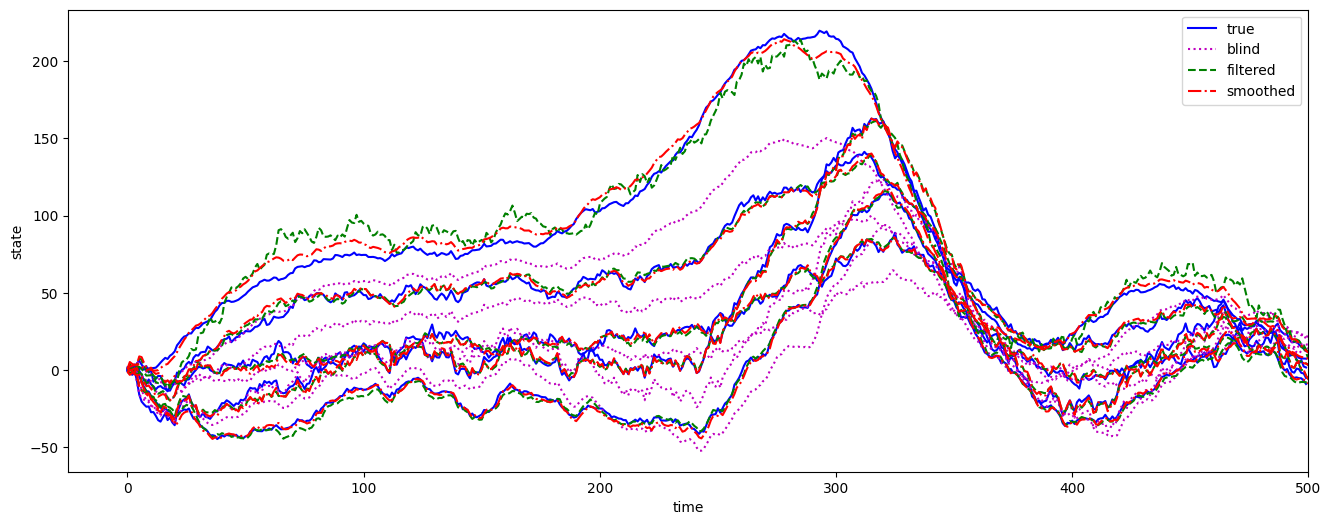

In [10]:
pl.figure(figsize=(16, 6))
lines_true = pl.plot(data.states, linestyle="-", color="b")
lines_blind = pl.plot(blind_state_estimates, linestyle=":", color="m")
lines_filt = pl.plot(filtered_state_estimates, linestyle="--", color="g")
lines_smooth = pl.plot(smoothed_state_estimates, linestyle="-.", color="r")
pl.legend(
    (lines_true[0], lines_blind[0], lines_filt[0], lines_smooth[0]),
    ("true", "blind", "filtered", "smoothed"),
)
pl.xlabel("time")
pl.ylabel("state")
pl.xlim(xmax=500)

Draw log likelihood of observations as a function of EM iteration number.

***Notice how it is increasing (this is guaranteed by the EM algorithm)***

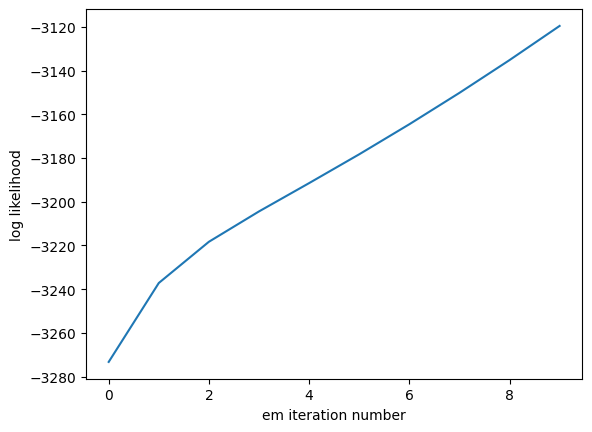

In [11]:
pl.figure()
pl.plot(loglikelihoods)
pl.xlabel("em iteration number")
pl.ylabel("log likelihood")
pl.show()